# Customer Satisfaction Prediction
### Predicting customer satisfaction ratings from support ticket data

---

In this notebook, I'll be working with customer support ticket data to build a model that predicts satisfaction ratings. The goal is to understand what factors influence customer satisfaction and whether we can predict it based on ticket characteristics.


## 1. Setup and Imports

First, let me import all the libraries I'll need for this analysis.

In [1]:
# data manipulation
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ml stuff
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

import warnings
warnings.filterwarnings('ignore')

# setting up plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# create output folder for saving plots
import os
os.makedirs('outputs', exist_ok=True)
os.makedirs('outputs/visualizations', exist_ok=True)

print('All libraries are imported')

All libraries are imported


## 2. Loading the Data

Let's load our dataset and see what we're working with.

In [2]:
# loading the data
df = pd.read_csv('/content/customer_support_tickets.csv')

print(f'Dataset size: {df.shape[0]} rows, {df.shape[1]} columns')
print('\nColumns in our dataset:')
for i, col in enumerate(df.columns, 1):
    print(f'  {i}. {col}')

Dataset size: 8469 rows, 17 columns

Columns in our dataset:
  1. Ticket ID
  2. Customer Name
  3. Customer Email
  4. Customer Age
  5. Customer Gender
  6. Product Purchased
  7. Date of Purchase
  8. Ticket Type
  9. Ticket Subject
  10. Ticket Description
  11. Ticket Status
  12. Resolution
  13. Ticket Priority
  14. Ticket Channel
  15. First Response Time
  16. Time to Resolution
  17. Customer Satisfaction Rating


In [3]:
# quick peek at the data
df.head()

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0


In [4]:
# checking data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticket ID                     8469 non-null   int64  
 1   Customer Name                 8469 non-null   object 
 2   Customer Email                8469 non-null   object 
 3   Customer Age                  8469 non-null   int64  
 4   Customer Gender               8469 non-null   object 
 5   Product Purchased             8469 non-null   object 
 6   Date of Purchase              8469 non-null   object 
 7   Ticket Type                   8469 non-null   object 
 8   Ticket Subject                8469 non-null   object 
 9   Ticket Description            8469 non-null   object 
 10  Ticket Status                 8469 non-null   object 
 11  Resolution                    2769 non-null   object 
 12  Ticket Priority               8469 non-null   object 
 13  Tic

In [5]:
# numerical summary
df.describe()

,Ticket ID,Customer Age,Customer Satisfaction Rating
count,8469.000000,8469.000000,2769.000000
mean,4235.000000,44.026804,2.991333
std,2444.934048,15.296112,1.407016
min,1.000000,18.000000,1.000000
25%,2118.000000,31.000000,2.000000
50%,4235.000000,44.000000,3.000000
75%,6352.000000,57.000000,4.000000
max,8469.000000,70.000000,5.000000


## 3. Data Quality Check

Before doing anything else, I need to check for missing values and understand data quality issues.

In [6]:
# missing values analysis
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
})

# only show columns with missing values
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing %', ascending=False)
print('Missing Values Summary:')
print('-' * 40)
print(missing_df)

Missing Values Summary:
----------------------------------------
                              Missing Count  Missing %
Resolution                             5700  67.304286
Time to Resolution                     5700  67.304286
Customer Satisfaction Rating           5700  67.304286
First Response Time                    2819  33.286102


 About 67% of records don't have satisfaction ratings - these are likely open/pending tickets. For our prediction task, we'll focus on tickets that have ratings (closed tickets).

In [7]:
# let's see unique values in categorical columns
cat_cols = ['Customer Gender', 'Ticket Type', 'Ticket Subject', 'Ticket Status',
            'Ticket Priority', 'Ticket Channel']

print('Unique values in categorical columns:')
print('-' * 40)
for col in cat_cols:
    print(f'{col}: {df[col].nunique()} unique values')
    print(f'  -> {df[col].unique()[:5]}...' if df[col].nunique() > 5 else f'  -> {list(df[col].unique())}')
    print()

Unique values in categorical columns:
----------------------------------------
Customer Gender: 3 unique values
  -> ['Other', 'Female', 'Male']

Ticket Type: 5 unique values
  -> ['Technical issue', 'Billing inquiry', 'Cancellation request', 'Product inquiry', 'Refund request']

Ticket Subject: 16 unique values
  -> ['Product setup' 'Peripheral compatibility' 'Network problem'
 'Account access' 'Data loss']...

Ticket Status: 3 unique values
  -> ['Pending Customer Response', 'Closed', 'Open']

Ticket Priority: 4 unique values
  -> ['Critical', 'Low', 'High', 'Medium']

Ticket Channel: 4 unique values
  -> ['Social media', 'Chat', 'Email', 'Phone']



## 4. Data Cleaning

Now let's clean up the data. I'll filter for records with satisfaction ratings and handle other issues.

In [8]:
# keep only rows with satisfaction ratings (our target variable)
data = df[df['Customer Satisfaction Rating'].notna()].copy()

print(f'Original records: {len(df)}')
print(f'Records with ratings: {len(data)}')
print(f'Removed: {len(df) - len(data)} records (no ratings)')

Original records: 8469
Records with ratings: 2769
Removed: 5700 records (no ratings)


In [9]:
# check for duplicates
dupes = data['Ticket ID'].duplicated().sum()
print(f'Duplicate ticket IDs: {dupes}')

if dupes > 0:
    data = data.drop_duplicates(subset=['Ticket ID'])
    print(f'After removing duplicates: {len(data)} records')

Duplicate ticket IDs: 0


In [10]:
# convert date columns
data['Date of Purchase'] = pd.to_datetime(data['Date of Purchase'])
data['First Response Time'] = pd.to_datetime(data['First Response Time'])
data['Time to Resolution'] = pd.to_datetime(data['Time to Resolution'])

# convert satisfaction to integer (1-5)
data['Satisfaction'] = data['Customer Satisfaction Rating'].astype(int)

print('Date columns converted successfully!')
print(f'Satisfaction ratings range: {data["Satisfaction"].min()} to {data["Satisfaction"].max()}')

Date columns converted successfully!
Satisfaction ratings range: 1 to 5


In [11]:
# save cleaned data
data.to_csv('outputs/cleaned_data.csv', index=False)
print('Cleaned data saved to outputs/cleaned_data.csv')

Cleaned data saved to outputs/cleaned_data.csv


## 5. Feature Engineering

Let me create some new features that might help our model.

In [12]:
# time-based features from purchase date
data['Purchase_Year'] = data['Date of Purchase'].dt.year
data['Purchase_Month'] = data['Date of Purchase'].dt.month
data['Purchase_DayOfWeek'] = data['Date of Purchase'].dt.dayofweek
data['Purchase_Quarter'] = data['Date of Purchase'].dt.quarter

print('Created: Purchase_Year, Purchase_Month, Purchase_DayOfWeek, Purchase_Quarter')

Created: Purchase_Year, Purchase_Month, Purchase_DayOfWeek, Purchase_Quarter


In [13]:
# calculate resolution time (how long it took to resolve the ticket)
data['Resolution_Hours'] = (data['Time to Resolution'] - data['First Response Time']).dt.total_seconds() / 3600

# some values are negative (probably data entry errors), let's handle that
negative_count = (data['Resolution_Hours'] < 0).sum()
print(f'Found {negative_count} tickets with negative resolution time (data quality issue)')

# replace negatives with median
median_resolution = data.loc[data['Resolution_Hours'] >= 0, 'Resolution_Hours'].median()
data.loc[data['Resolution_Hours'] < 0, 'Resolution_Hours'] = median_resolution

print(f'Median resolution time: {median_resolution:.1f} hours')

Found 1365 tickets with negative resolution time (data quality issue)
Median resolution time: 6.3 hours


In [14]:
# create age groups - might be useful for segmentation
bins = [0, 25, 35, 45, 55, 65, 100]
labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '65+']
data['Age_Group'] = pd.cut(data['Customer Age'], bins=bins, labels=labels)

print('Age groups created:')
print(data['Age_Group'].value_counts().sort_index())

Age groups created:
Age_Group
18-25    390
26-35    515
36-45    532
46-55    542
56-65    528
65+      262
Name: count, dtype: int64


In [15]:
# ticket description length - longer descriptions might indicate more complex issues
data['Description_Length'] = data['Ticket Description'].str.len()

print(f'Description length stats:')
print(f'  Min: {data["Description_Length"].min()}')
print(f'  Max: {data["Description_Length"].max()}')
print(f'  Mean: {data["Description_Length"].mean():.0f}')

Description length stats:
  Min: 151
  Max: 397
  Mean: 290


## 6. Exploratory Data Analysis (EDA)

Time to dig into the data and understand patterns. I'll create visualizations and save them as we go.

### 6.1 Target Variable Distribution

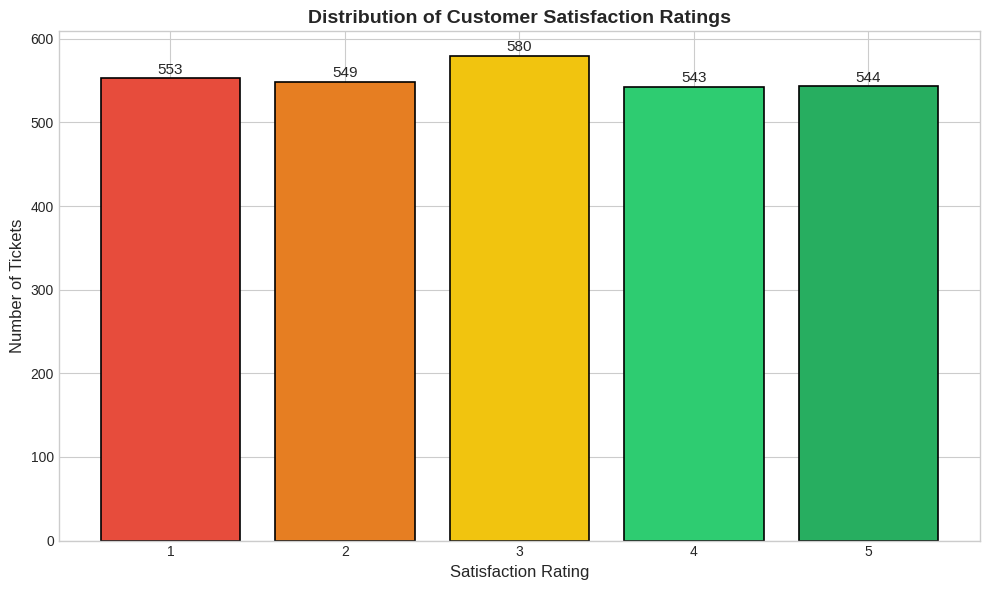


Average satisfaction: 2.99/5


In [16]:
# satisfaction rating distribution
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#e74c3c', '#e67e22', '#f1c40f', '#2ecc71', '#27ae60']
satisfaction_counts = data['Satisfaction'].value_counts().sort_index()

bars = ax.bar(satisfaction_counts.index, satisfaction_counts.values, color=colors, edgecolor='black', linewidth=1.2)

# add count labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 5, f'{int(height)}', ha='center', fontsize=11)

ax.set_xlabel('Satisfaction Rating', fontsize=12)
ax.set_ylabel('Number of Tickets', fontsize=12)
ax.set_title('Distribution of Customer Satisfaction Ratings', fontsize=14, fontweight='bold')
ax.set_xticks([1, 2, 3, 4, 5])

plt.tight_layout()
plt.savefig('outputs/visualizations/01_satisfaction_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\nAverage satisfaction: {data["Satisfaction"].mean():.2f}/5')

The distribution is fairly even across all ratings. Average is around 3/5 which suggests room for improvement.

### 6.2 Satisfaction by Different Categories

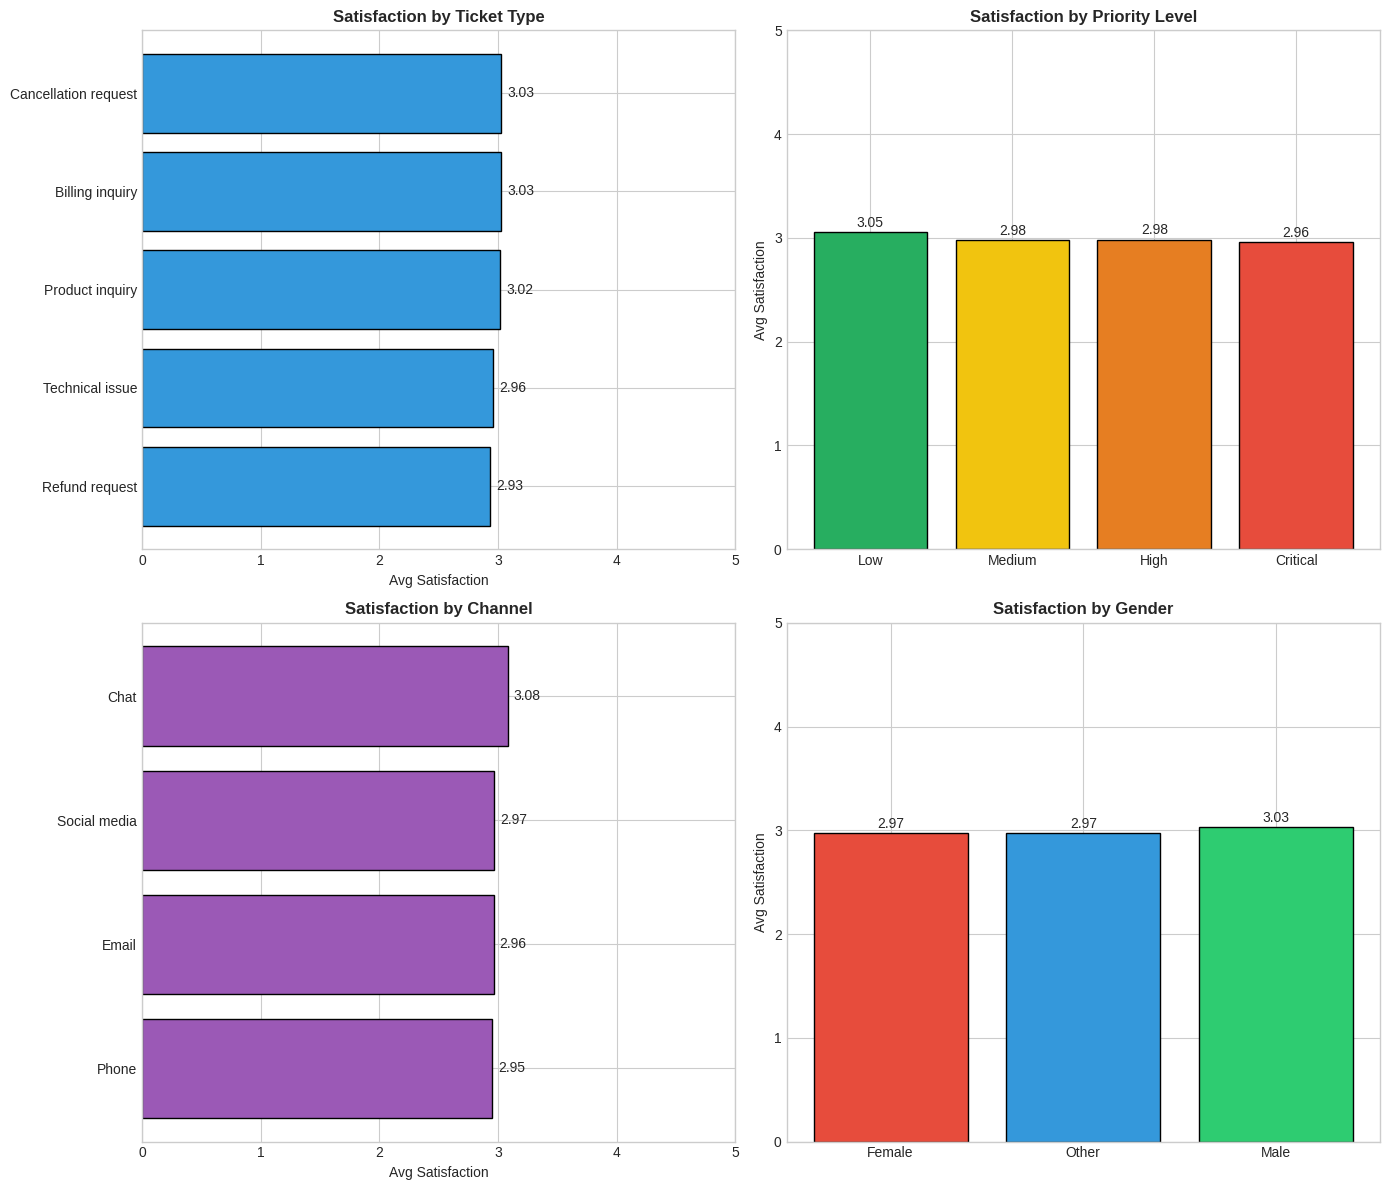

In [17]:
# satisfaction by ticket type
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# by ticket type
ax1 = axes[0, 0]
type_sat = data.groupby('Ticket Type')['Satisfaction'].mean().sort_values(ascending=True)
bars1 = ax1.barh(type_sat.index, type_sat.values, color='#3498db', edgecolor='black')
ax1.set_xlabel('Avg Satisfaction')
ax1.set_title('Satisfaction by Ticket Type', fontweight='bold')
ax1.set_xlim(0, 5)
for i, v in enumerate(type_sat.values):
    ax1.text(v + 0.05, i, f'{v:.2f}', va='center')

# by priority
ax2 = axes[0, 1]
priority_order = ['Low', 'Medium', 'High', 'Critical']
priority_sat = data.groupby('Ticket Priority')['Satisfaction'].mean().reindex(priority_order)
colors_p = ['#27ae60', '#f1c40f', '#e67e22', '#e74c3c']
bars2 = ax2.bar(priority_sat.index, priority_sat.values, color=colors_p, edgecolor='black')
ax2.set_ylabel('Avg Satisfaction')
ax2.set_title('Satisfaction by Priority Level', fontweight='bold')
ax2.set_ylim(0, 5)
for bar in bars2:
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.05, f'{bar.get_height():.2f}', ha='center')

# by channel
ax3 = axes[1, 0]
channel_sat = data.groupby('Ticket Channel')['Satisfaction'].mean().sort_values(ascending=True)
bars3 = ax3.barh(channel_sat.index, channel_sat.values, color='#9b59b6', edgecolor='black')
ax3.set_xlabel('Avg Satisfaction')
ax3.set_title('Satisfaction by Channel', fontweight='bold')
ax3.set_xlim(0, 5)
for i, v in enumerate(channel_sat.values):
    ax3.text(v + 0.05, i, f'{v:.2f}', va='center')

# by gender
ax4 = axes[1, 1]
gender_sat = data.groupby('Customer Gender')['Satisfaction'].mean().sort_values(ascending=True)
bars4 = ax4.bar(gender_sat.index, gender_sat.values, color=['#e74c3c', '#3498db', '#2ecc71'], edgecolor='black')
ax4.set_ylabel('Avg Satisfaction')
ax4.set_title('Satisfaction by Gender', fontweight='bold')
ax4.set_ylim(0, 5)
for bar in bars4:
    ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.05, f'{bar.get_height():.2f}', ha='center')

plt.tight_layout()
plt.savefig('outputs/visualizations/02_satisfaction_by_category.png', dpi=150, bbox_inches='tight')
plt.show()

### 6.3 Customer Demographics

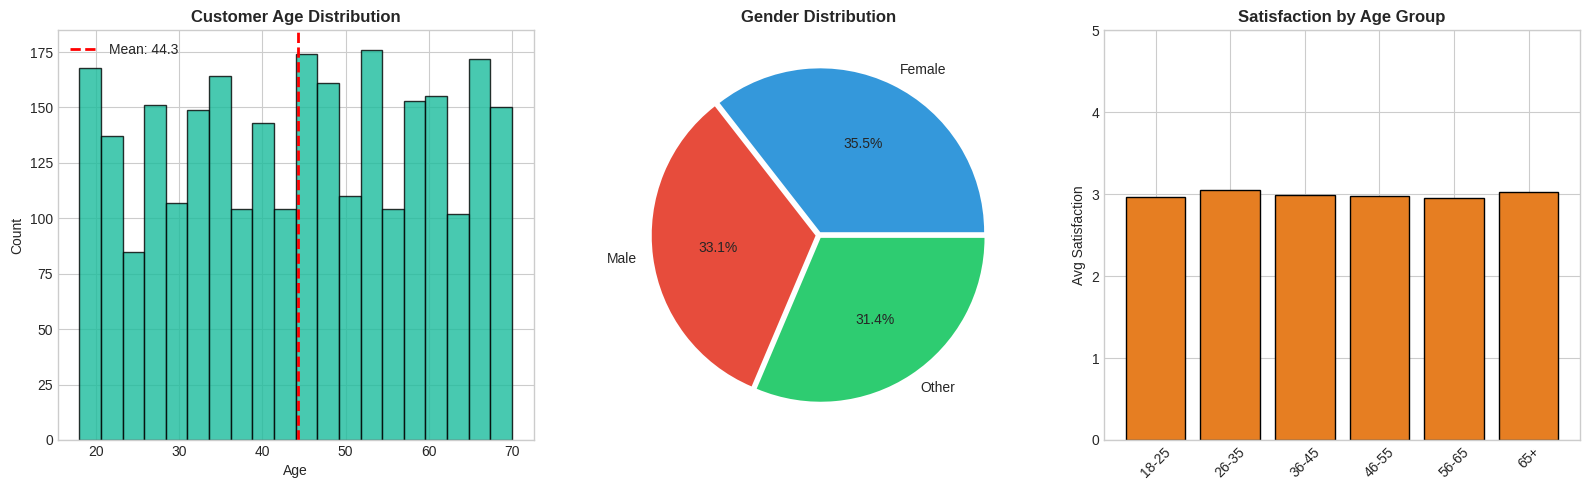

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# age distribution
ax1 = axes[0]
ax1.hist(data['Customer Age'], bins=20, color='#1abc9c', edgecolor='black', alpha=0.8)
ax1.axvline(data['Customer Age'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data["Customer Age"].mean():.1f}')
ax1.set_xlabel('Age')
ax1.set_ylabel('Count')
ax1.set_title('Customer Age Distribution', fontweight='bold')
ax1.legend()

# gender distribution
ax2 = axes[1]
gender_counts = data['Customer Gender'].value_counts()
ax2.pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%',
        colors=['#3498db', '#e74c3c', '#2ecc71'], explode=[0.02]*len(gender_counts))
ax2.set_title('Gender Distribution', fontweight='bold')

# age group vs satisfaction
ax3 = axes[2]
age_sat = data.groupby('Age_Group')['Satisfaction'].mean()
bars = ax3.bar(range(len(age_sat)), age_sat.values, color='#e67e22', edgecolor='black')
ax3.set_xticks(range(len(age_sat)))
ax3.set_xticklabels(age_sat.index, rotation=45)
ax3.set_ylabel('Avg Satisfaction')
ax3.set_title('Satisfaction by Age Group', fontweight='bold')
ax3.set_ylim(0, 5)

plt.tight_layout()
plt.savefig('outputs/visualizations/03_customer_demographics.png', dpi=150, bbox_inches='tight')
plt.show()

### 6.4 Ticket Analysis

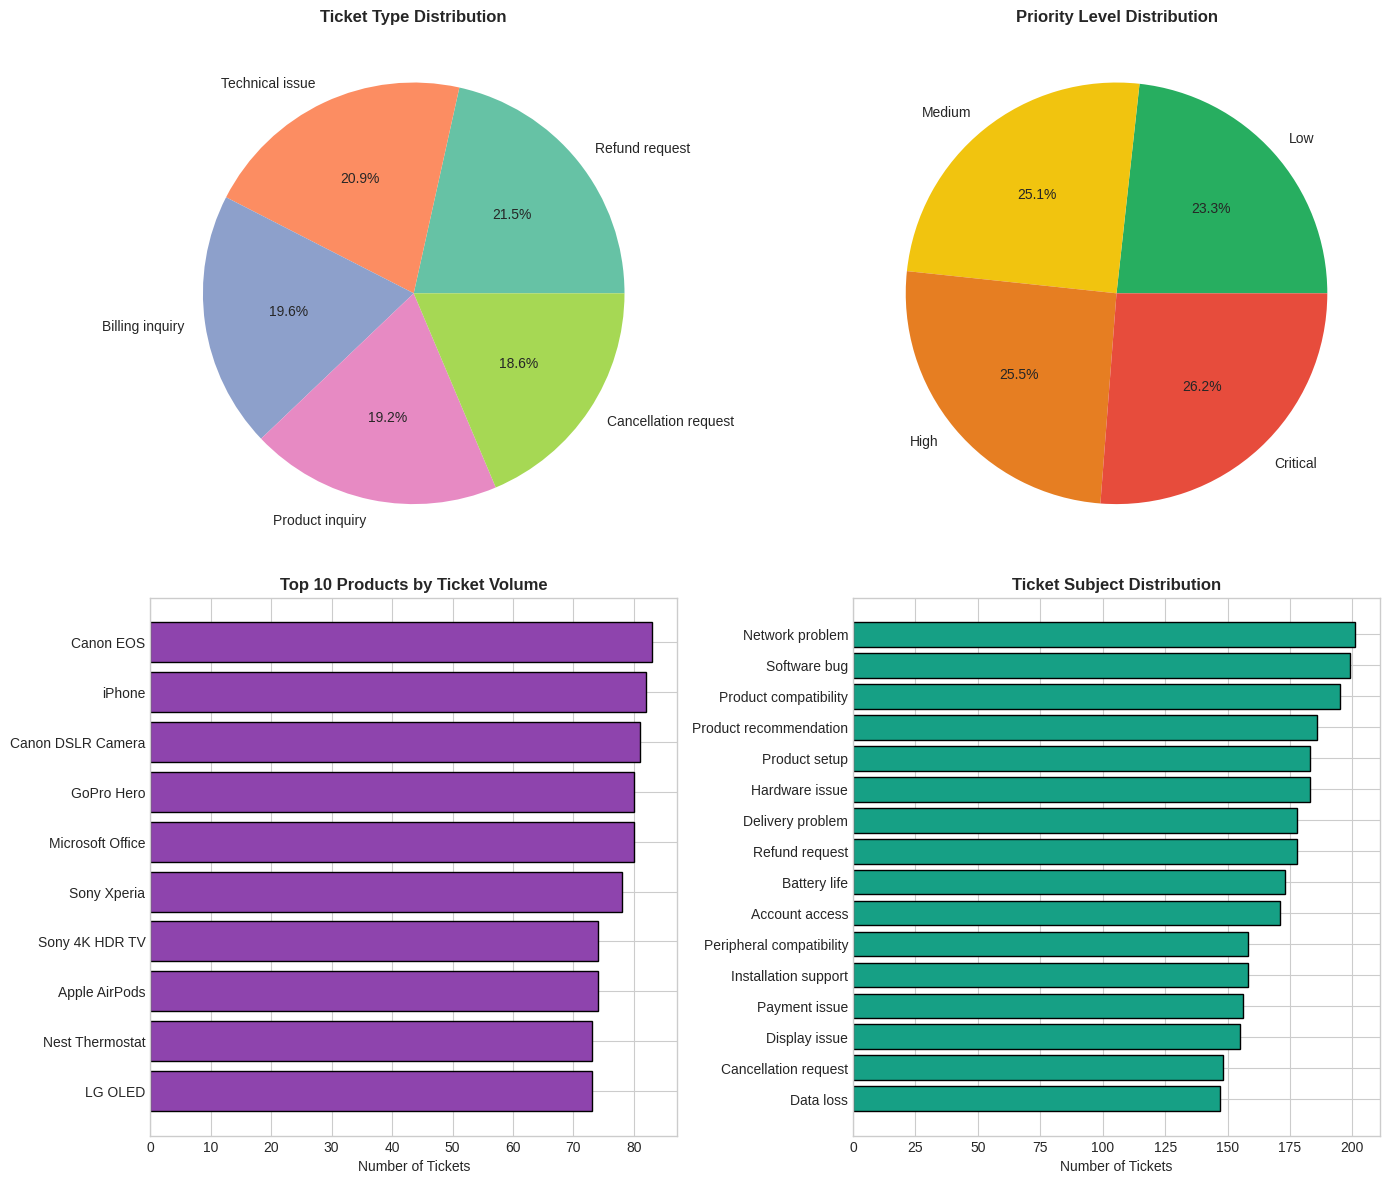

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# ticket type distribution
ax1 = axes[0, 0]
type_counts = data['Ticket Type'].value_counts()
ax1.pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%',
        colors=sns.color_palette('Set2'))
ax1.set_title('Ticket Type Distribution', fontweight='bold')

# priority distribution
ax2 = axes[0, 1]
priority_counts = data['Ticket Priority'].value_counts().reindex(['Low', 'Medium', 'High', 'Critical'])
ax2.pie(priority_counts.values, labels=priority_counts.index, autopct='%1.1f%%',
        colors=['#27ae60', '#f1c40f', '#e67e22', '#e74c3c'])
ax2.set_title('Priority Level Distribution', fontweight='bold')

# top 10 products
ax3 = axes[1, 0]
top_products = data['Product Purchased'].value_counts().head(10)
ax3.barh(top_products.index, top_products.values, color='#8e44ad', edgecolor='black')
ax3.set_xlabel('Number of Tickets')
ax3.set_title('Top 10 Products by Ticket Volume', fontweight='bold')
ax3.invert_yaxis()

# ticket subject distribution
ax4 = axes[1, 1]
subject_counts = data['Ticket Subject'].value_counts()
ax4.barh(subject_counts.index, subject_counts.values, color='#16a085', edgecolor='black')
ax4.set_xlabel('Number of Tickets')
ax4.set_title('Ticket Subject Distribution', fontweight='bold')
ax4.invert_yaxis()

plt.tight_layout()
plt.savefig('outputs/visualizations/04_ticket_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

### 6.5 Resolution Time Analysis

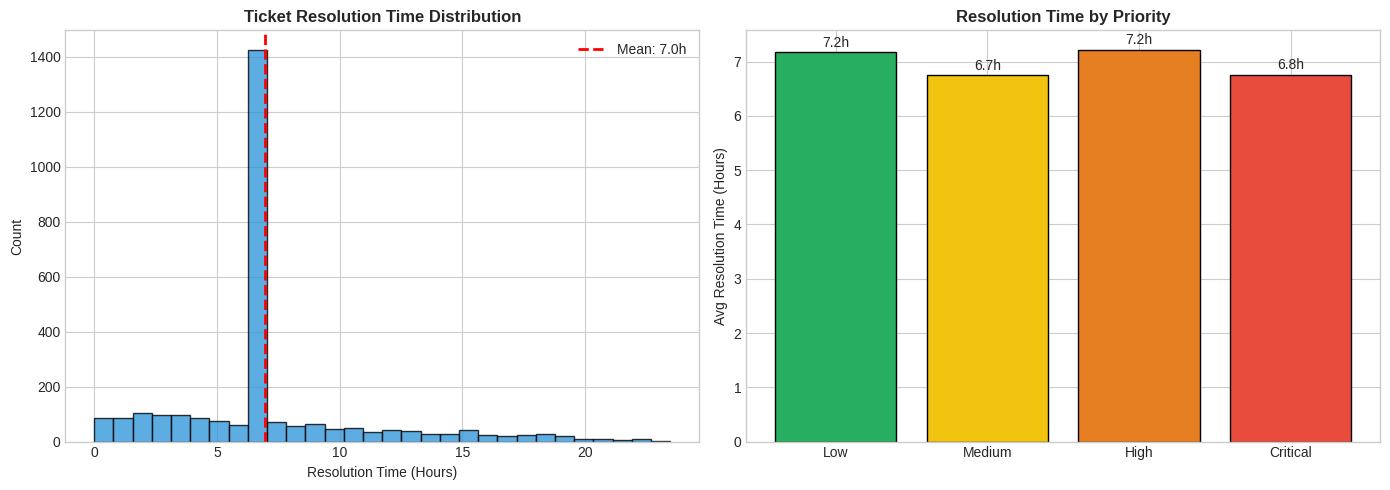

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# resolution time distribution (filter outliers for better viz)
ax1 = axes[0]
resolution_filtered = data[data['Resolution_Hours'] <= 30]['Resolution_Hours']
ax1.hist(resolution_filtered, bins=30, color='#3498db', edgecolor='black', alpha=0.8)
ax1.axvline(resolution_filtered.mean(), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {resolution_filtered.mean():.1f}h')
ax1.set_xlabel('Resolution Time (Hours)')
ax1.set_ylabel('Count')
ax1.set_title('Ticket Resolution Time Distribution', fontweight='bold')
ax1.legend()

# resolution time by priority
ax2 = axes[1]
resolution_by_priority = data.groupby('Ticket Priority')['Resolution_Hours'].mean().reindex(priority_order)
bars = ax2.bar(resolution_by_priority.index, resolution_by_priority.values,
               color=['#27ae60', '#f1c40f', '#e67e22', '#e74c3c'], edgecolor='black')
ax2.set_ylabel('Avg Resolution Time (Hours)')
ax2.set_title('Resolution Time by Priority', fontweight='bold')
for bar in bars:
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1,
             f'{bar.get_height():.1f}h', ha='center')

plt.tight_layout()
plt.savefig('outputs/visualizations/05_resolution_time.png', dpi=150, bbox_inches='tight')
plt.show()

### 6.6 Correlation Analysis

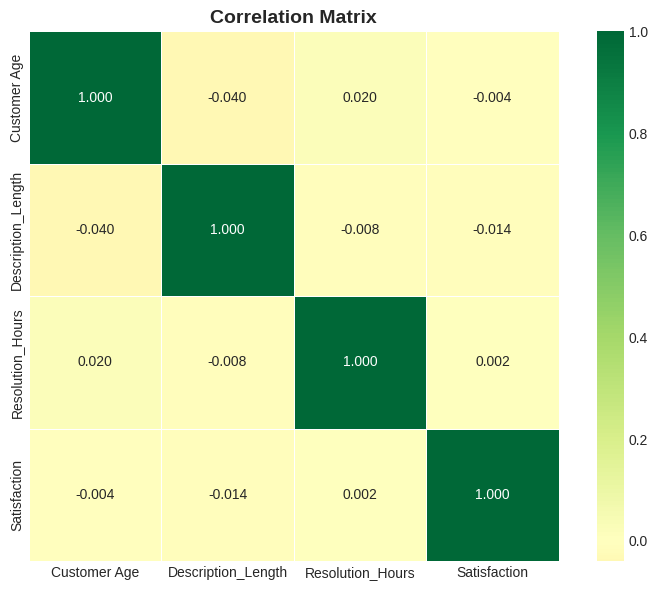


Correlation with Satisfaction:
Satisfaction          1.000000
Resolution_Hours      0.001627
Customer Age         -0.003700
Description_Length   -0.014469
Name: Satisfaction, dtype: float64


In [21]:
# correlation heatmap
numeric_cols = ['Customer Age', 'Description_Length', 'Resolution_Hours', 'Satisfaction']
corr_matrix = data[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.3f',
            square=True, linewidths=0.5, ax=ax)
ax.set_title('Correlation Matrix', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.savefig('outputs/visualizations/06_correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nCorrelation with Satisfaction:')
print(corr_matrix['Satisfaction'].sort_values(ascending=False))

### 6.7 Satisfaction Heatmap by Type and Priority

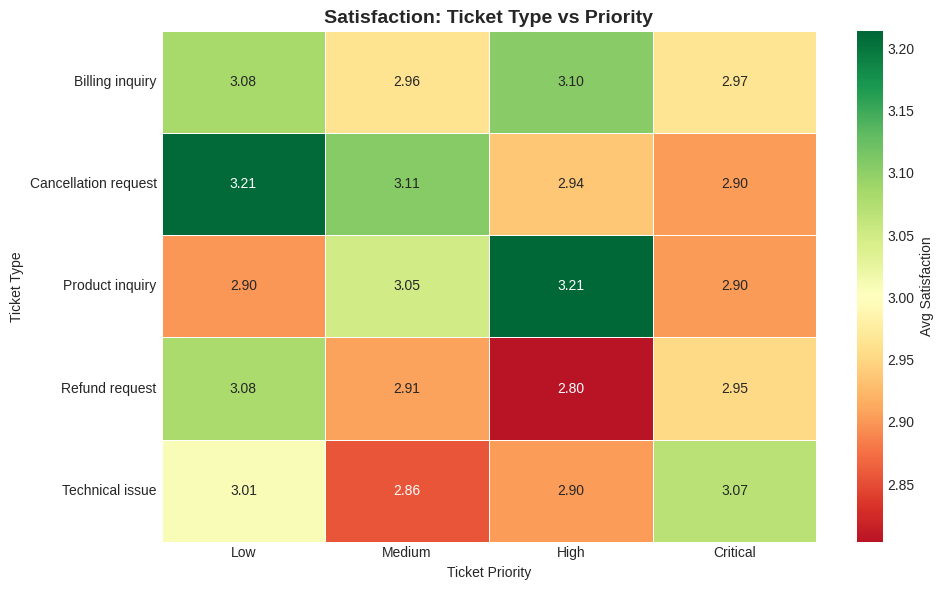

In [22]:
# create pivot table for heatmap
pivot = data.pivot_table(values='Satisfaction', index='Ticket Type',
                         columns='Ticket Priority', aggfunc='mean')
pivot = pivot.reindex(columns=['Low', 'Medium', 'High', 'Critical'])

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt='.2f', cmap='RdYlGn', center=3,
            linewidths=0.5, ax=ax, cbar_kws={'label': 'Avg Satisfaction'})
ax.set_title('Satisfaction: Ticket Type vs Priority', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.savefig('outputs/visualizations/07_satisfaction_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Preparing Data for Machine Learning

 Preparing the features for our models.

In [23]:
# select features for modeling
features = ['Customer Age', 'Customer Gender', 'Product Purchased', 'Ticket Type',
            'Ticket Subject', 'Ticket Priority', 'Ticket Channel',
            'Purchase_Month', 'Purchase_DayOfWeek', 'Purchase_Quarter',
            'Description_Length', 'Resolution_Hours']

# create modeling dataset
model_df = data[features + ['Satisfaction']].copy()

# fill any remaining nulls
model_df['Resolution_Hours'] = model_df['Resolution_Hours'].fillna(model_df['Resolution_Hours'].median())
model_df['Description_Length'] = model_df['Description_Length'].fillna(model_df['Description_Length'].median())
model_df = model_df.dropna()

print(f'Records for modeling: {len(model_df)}')

Records for modeling: 2769


In [24]:
# encode categorical variables
encoders = {}
cat_features = ['Customer Gender', 'Product Purchased', 'Ticket Type',
                'Ticket Subject', 'Ticket Priority', 'Ticket Channel']

for col in cat_features:
    encoders[col] = LabelEncoder()
    model_df[col] = encoders[col].fit_transform(model_df[col])
    print(f'Encoded {col}: {len(encoders[col].classes_)} categories')

Encoded Customer Gender: 3 categories
Encoded Product Purchased: 42 categories
Encoded Ticket Type: 5 categories
Encoded Ticket Subject: 16 categories
Encoded Ticket Priority: 4 categories
Encoded Ticket Channel: 4 categories


In [25]:
# split features and target
X = model_df.drop('Satisfaction', axis=1)
y = model_df['Satisfaction']

print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')
print(f'\nTarget distribution:')
print(y.value_counts().sort_index())

Features shape: (2769, 12)
Target shape: (2769,)

Target distribution:
Satisfaction
1    553
2    549
3    580
4    543
5    544
Name: count, dtype: int64


In [26]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

print(f'Training set: {len(X_train)} samples')
print(f'Test set: {len(X_test)} samples')

Training set: 2215 samples
Test set: 554 samples


In [27]:
# scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Features scaled successfully!')

Features scaled successfully!


## 8. Model Training and Evaluation

Let's train several models and compare their performance.

In [29]:
# define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# store results
results = []

print('Training models...')


for name, model in models.items():
    print(f'\n>> {name}')

    # train
    model.fit(X_train_scaled, y_train)

    # predict
    y_pred = model.predict(X_test_scaled)

    # metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    cv = cross_val_score(model, X_train_scaled, y_train, cv=5).mean()

    results.append({
        'Model': name,
        'Accuracy': acc,
        'F1 Score': f1,
        'CV Score': cv
    })

    print(f'   Accuracy: {acc:.4f}')
    print(f'   F1 Score: {f1:.4f}')
    print(f'   CV Score: {cv:.4f}')


print('Training complete!')

Training models...

>> Logistic Regression
   Accuracy: 0.1968
   F1 Score: 0.1895
   CV Score: 0.2032

>> Decision Tree
   Accuracy: 0.1895
   F1 Score: 0.1887
   CV Score: 0.1973

>> Random Forest
   Accuracy: 0.2148
   F1 Score: 0.2142
   CV Score: 0.1896

>> Gradient Boosting
   Accuracy: 0.1805
   F1 Score: 0.1802
   CV Score: 0.1837

>> KNN
   Accuracy: 0.2238
   F1 Score: 0.2179
   CV Score: 0.2005
Training complete!


In [30]:
# results comparison
results_df = pd.DataFrame(results).sort_values('Accuracy', ascending=False)
print('\nModel Comparison:')
print(results_df.to_string(index=False))

# save results
results_df.to_csv('outputs/model_results.csv', index=False)



Model Comparison:
              Model  Accuracy  F1 Score  CV Score
                KNN  0.223827  0.217893  0.200451
      Random Forest  0.214801  0.214189  0.189616
Logistic Regression  0.196751  0.189492  0.203160
      Decision Tree  0.189531  0.188748  0.197291
  Gradient Boosting  0.180505  0.180176  0.183747


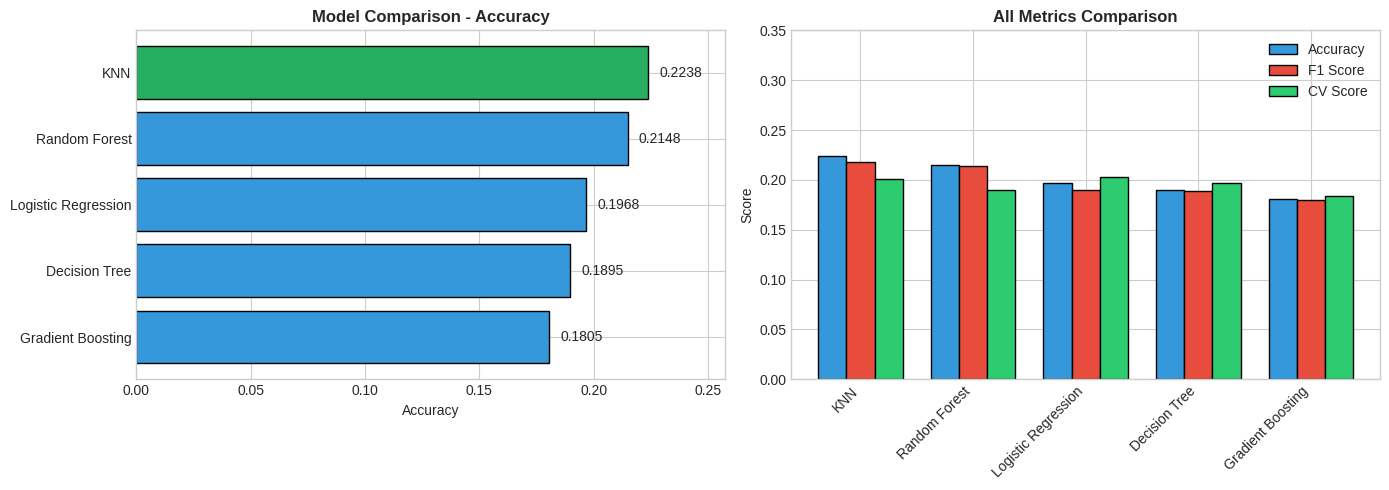

In [31]:
# visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# accuracy comparison
ax1 = axes[0]
results_sorted = results_df.sort_values('Accuracy', ascending=True)
colors = ['#3498db' if x != results_sorted['Model'].iloc[-1] else '#27ae60'
          for x in results_sorted['Model']]
bars1 = ax1.barh(results_sorted['Model'], results_sorted['Accuracy'], color=colors, edgecolor='black')
ax1.set_xlabel('Accuracy')
ax1.set_title('Model Comparison - Accuracy', fontweight='bold')
ax1.set_xlim(0, max(results_sorted['Accuracy']) * 1.15)
for i, v in enumerate(results_sorted['Accuracy']):
    ax1.text(v + 0.005, i, f'{v:.4f}', va='center')

# all metrics comparison
ax2 = axes[1]
x = np.arange(len(results_df))
width = 0.25
ax2.bar(x - width, results_df['Accuracy'], width, label='Accuracy', color='#3498db', edgecolor='black')
ax2.bar(x, results_df['F1 Score'], width, label='F1 Score', color='#e74c3c', edgecolor='black')
ax2.bar(x + width, results_df['CV Score'], width, label='CV Score', color='#2ecc71', edgecolor='black')
ax2.set_xticks(x)
ax2.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax2.set_ylabel('Score')
ax2.set_title('All Metrics Comparison', fontweight='bold')
ax2.legend()
ax2.set_ylim(0, 0.35)

plt.tight_layout()
plt.savefig('outputs/visualizations/08_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Best Model Analysis

Let's dive deeper into our best performing model.

In [32]:
# get best model
best_model_name = results_df.iloc[0]['Model']
print(f'Best Model: {best_model_name}')
print(f'Accuracy: {results_df.iloc[0]["Accuracy"]:.4f}')

Best Model: KNN
Accuracy: 0.2238


In [33]:
# train random forest for feature importance (it's usually one of the best)
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

# classification report
print('Classification Report (Random Forest):')
print('=' * 50)
print(classification_report(y_test, y_pred_rf))

Classification Report (Random Forest):
              precision    recall  f1-score   support

           1       0.24      0.26      0.25       111
           2       0.22      0.23      0.22       110
           3       0.21      0.21      0.21       116
           4       0.17      0.16      0.16       108
           5       0.23      0.22      0.23       109

    accuracy                           0.21       554
   macro avg       0.21      0.21      0.21       554
weighted avg       0.21      0.21      0.21       554



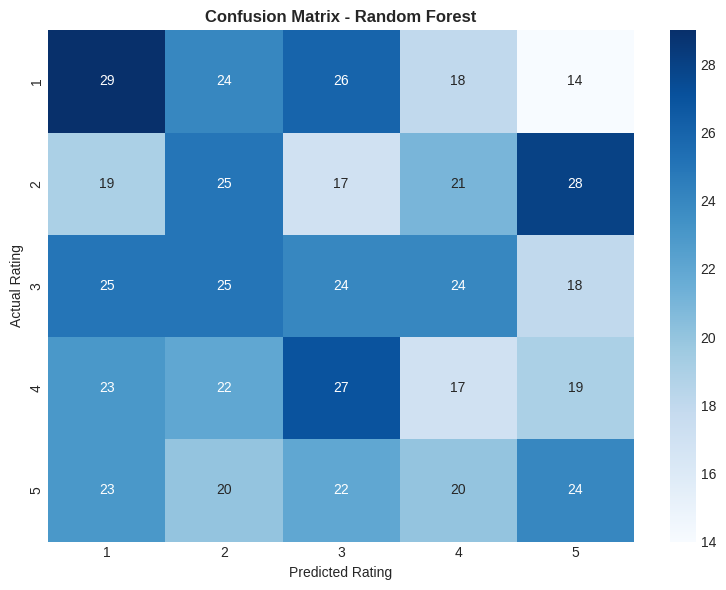

In [34]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
ax.set_xlabel('Predicted Rating')
ax.set_ylabel('Actual Rating')
ax.set_title('Confusion Matrix - Random Forest', fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/visualizations/09_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

In [35]:
# feature importance
feature_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print('Feature Importance:')
print(feature_imp.to_string(index=False))

# save feature importance
feature_imp.to_csv('outputs/feature_importance.csv', index=False)

Feature Importance:
           Feature  Importance
Description_Length    0.137674
      Customer Age    0.127682
 Product Purchased    0.119586
    Ticket Subject    0.101129
  Resolution_Hours    0.096480
    Purchase_Month    0.083884
Purchase_DayOfWeek    0.077054
       Ticket Type    0.064294
    Ticket Channel    0.057371
   Ticket Priority    0.054849
   Customer Gender    0.042690
  Purchase_Quarter    0.037307


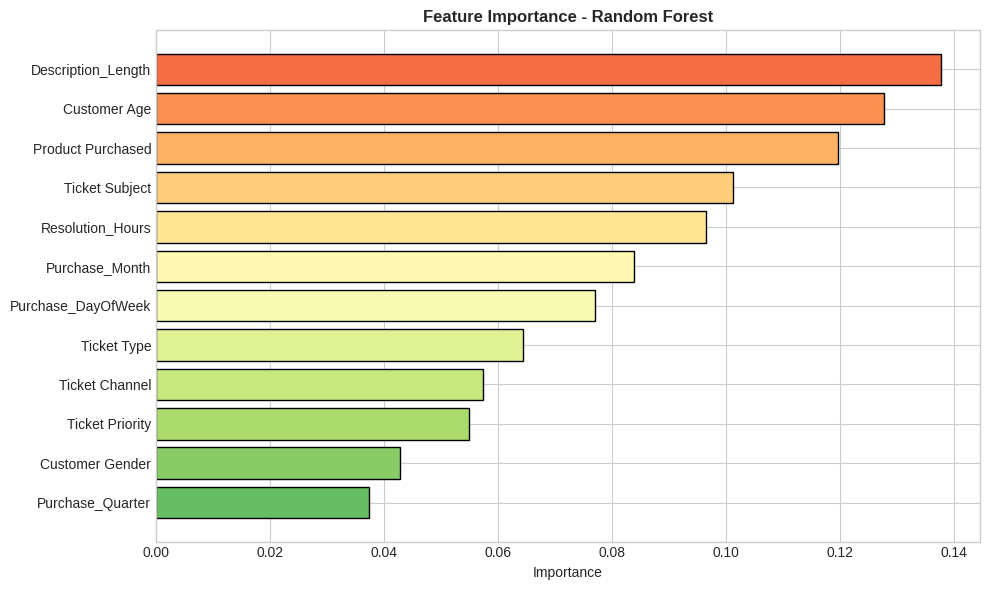

In [36]:
# visualize feature importance
fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(feature_imp)))
bars = ax.barh(feature_imp['Feature'], feature_imp['Importance'], color=colors, edgecolor='black')
ax.set_xlabel('Importance')
ax.set_title('Feature Importance - Random Forest', fontweight='bold')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('outputs/visualizations/10_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Dashboard Summary

Let's create a comprehensive dashboard that summarizes all our findings.

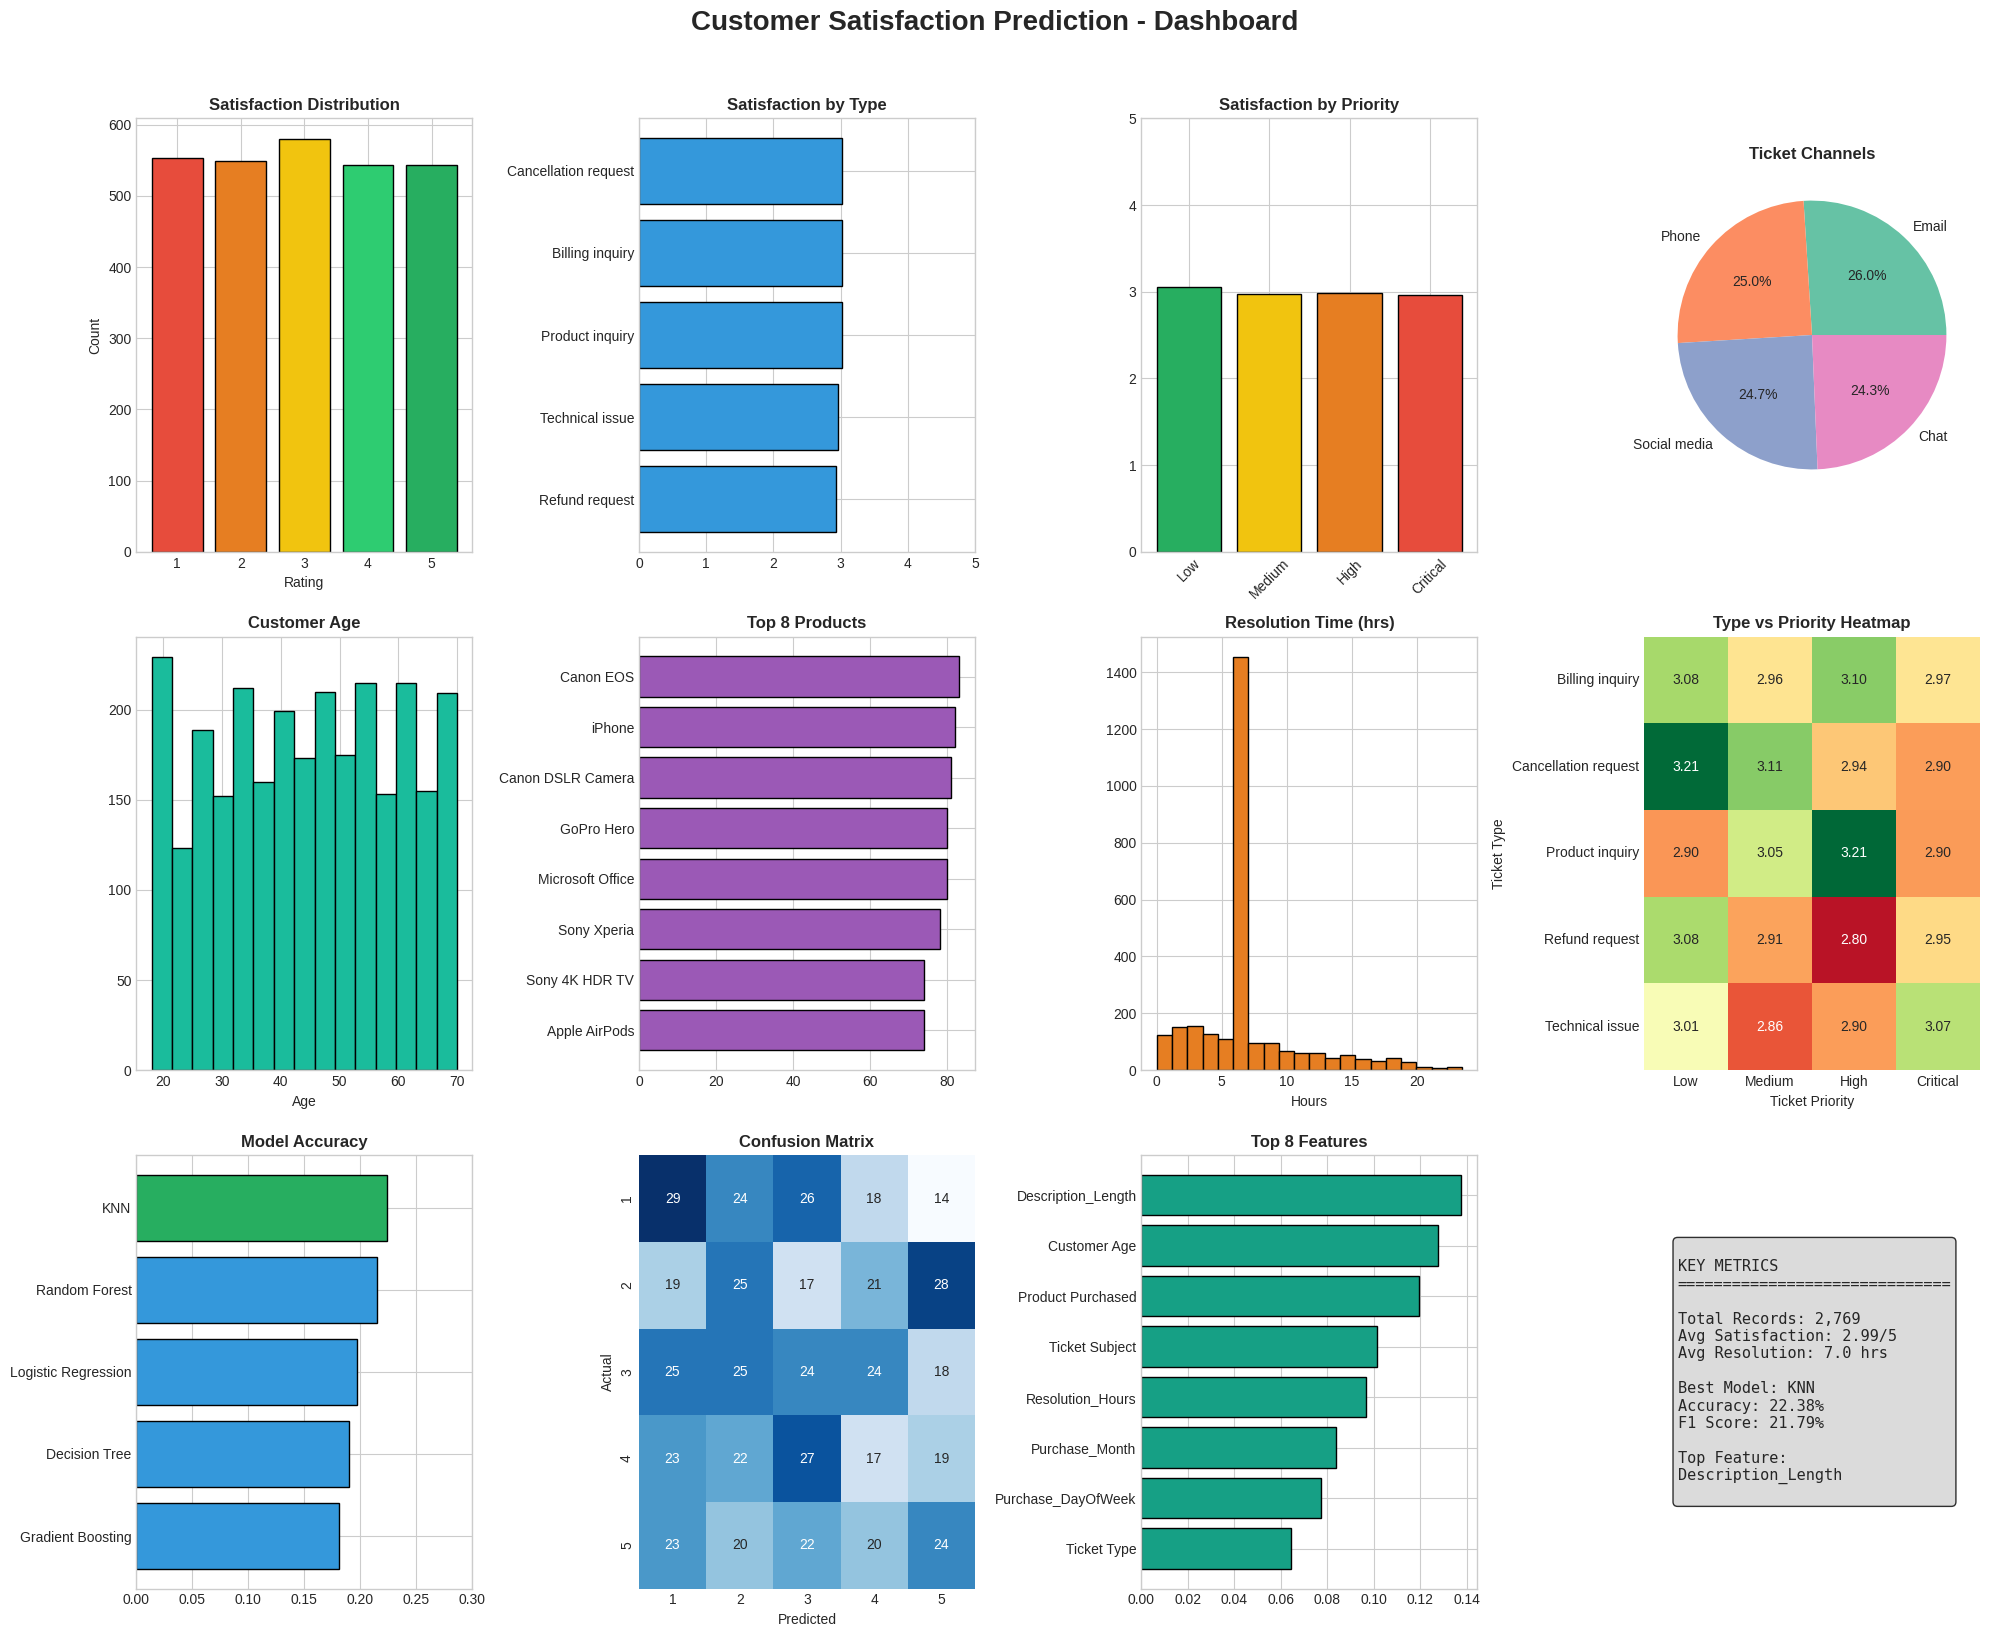


Dashboard saved to outputs/visualizations/11_dashboard.png


In [37]:
# create comprehensive dashboard
fig = plt.figure(figsize=(20, 16))

# title
fig.suptitle('Customer Satisfaction Prediction - Dashboard', fontsize=20, fontweight='bold', y=1.02)

# 1. satisfaction distribution
ax1 = fig.add_subplot(3, 4, 1)
colors_sat = ['#e74c3c', '#e67e22', '#f1c40f', '#2ecc71', '#27ae60']
sat_counts = data['Satisfaction'].value_counts().sort_index()
ax1.bar(sat_counts.index, sat_counts.values, color=colors_sat, edgecolor='black')
ax1.set_title('Satisfaction Distribution', fontweight='bold')
ax1.set_xlabel('Rating')
ax1.set_ylabel('Count')

# 2. by ticket type
ax2 = fig.add_subplot(3, 4, 2)
type_sat = data.groupby('Ticket Type')['Satisfaction'].mean().sort_values()
ax2.barh(type_sat.index, type_sat.values, color='#3498db', edgecolor='black')
ax2.set_title('Satisfaction by Type', fontweight='bold')
ax2.set_xlim(0, 5)

# 3. by priority
ax3 = fig.add_subplot(3, 4, 3)
priority_sat = data.groupby('Ticket Priority')['Satisfaction'].mean().reindex(['Low', 'Medium', 'High', 'Critical'])
ax3.bar(priority_sat.index, priority_sat.values, color=['#27ae60', '#f1c40f', '#e67e22', '#e74c3c'], edgecolor='black')
ax3.set_title('Satisfaction by Priority', fontweight='bold')
ax3.set_ylim(0, 5)
ax3.tick_params(axis='x', rotation=45)

# 4. channel distribution
ax4 = fig.add_subplot(3, 4, 4)
channel_counts = data['Ticket Channel'].value_counts()
ax4.pie(channel_counts.values, labels=channel_counts.index, autopct='%1.1f%%', colors=sns.color_palette('Set2'))
ax4.set_title('Ticket Channels', fontweight='bold')

# 5. age distribution
ax5 = fig.add_subplot(3, 4, 5)
ax5.hist(data['Customer Age'], bins=15, color='#1abc9c', edgecolor='black')
ax5.set_title('Customer Age', fontweight='bold')
ax5.set_xlabel('Age')

# 6. top products
ax6 = fig.add_subplot(3, 4, 6)
top_prods = data['Product Purchased'].value_counts().head(8)
ax6.barh(top_prods.index, top_prods.values, color='#9b59b6', edgecolor='black')
ax6.set_title('Top 8 Products', fontweight='bold')
ax6.invert_yaxis()

# 7. resolution time
ax7 = fig.add_subplot(3, 4, 7)
res_filtered = data[data['Resolution_Hours'] <= 25]['Resolution_Hours']
ax7.hist(res_filtered, bins=20, color='#e67e22', edgecolor='black')
ax7.set_title('Resolution Time (hrs)', fontweight='bold')
ax7.set_xlabel('Hours')

# 8. satisfaction heatmap
ax8 = fig.add_subplot(3, 4, 8)
pivot = data.pivot_table(values='Satisfaction', index='Ticket Type',
                         columns='Ticket Priority', aggfunc='mean')
pivot = pivot.reindex(columns=['Low', 'Medium', 'High', 'Critical'])
sns.heatmap(pivot, annot=True, fmt='.2f', cmap='RdYlGn', center=3, ax=ax8, cbar=False)
ax8.set_title('Type vs Priority Heatmap', fontweight='bold')

# 9. model comparison
ax9 = fig.add_subplot(3, 4, 9)
res_sorted = results_df.sort_values('Accuracy', ascending=True)
colors_model = ['#3498db' if x != res_sorted['Model'].iloc[-1] else '#27ae60' for x in res_sorted['Model']]
ax9.barh(res_sorted['Model'], res_sorted['Accuracy'], color=colors_model, edgecolor='black')
ax9.set_title('Model Accuracy', fontweight='bold')
ax9.set_xlim(0, 0.3)

# 10. confusion matrix
ax10 = fig.add_subplot(3, 4, 10)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax10, cbar=False,
            xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
ax10.set_title('Confusion Matrix', fontweight='bold')
ax10.set_xlabel('Predicted')
ax10.set_ylabel('Actual')

# 11. feature importance
ax11 = fig.add_subplot(3, 4, 11)
top_features = feature_imp.head(8)
ax11.barh(top_features['Feature'], top_features['Importance'], color='#16a085', edgecolor='black')
ax11.set_title('Top 8 Features', fontweight='bold')
ax11.invert_yaxis()

# 12. key metrics text box
ax12 = fig.add_subplot(3, 4, 12)
ax12.axis('off')
metrics_text = f"""
KEY METRICS
{'='*30}

Total Records: {len(data):,}
Avg Satisfaction: {data['Satisfaction'].mean():.2f}/5
Avg Resolution: {data['Resolution_Hours'].mean():.1f} hrs

Best Model: {results_df.iloc[0]['Model']}
Accuracy: {results_df.iloc[0]['Accuracy']:.2%}
F1 Score: {results_df.iloc[0]['F1 Score']:.2%}

Top Feature:
{feature_imp.iloc[0]['Feature']}
"""
ax12.text(0.1, 0.5, metrics_text, transform=ax12.transAxes, fontsize=11,
          verticalalignment='center', fontfamily='monospace',
          bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.savefig('outputs/visualizations/11_dashboard.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print('\nDashboard saved to outputs/visualizations/11_dashboard.png')

## 11. Summary and Conclusions

Let me wrap up what we found in this analysis.

In [38]:
print('=' * 60)
print('PROJECT SUMMARY')
print('=' * 60)

print(f'''
DATASET:
  - Total tickets analyzed: {len(data):,}
  - Features used: {len(features)}
  - Target: 5-class satisfaction rating (1-5)

KEY FINDINGS:
  - Average satisfaction: {data['Satisfaction'].mean():.2f}/5
  - Most common ticket type: {data['Ticket Type'].mode()[0]}
  - Most common priority: {data['Ticket Priority'].mode()[0]}
  - Average resolution time: {data['Resolution_Hours'].mean():.1f} hours

MODEL PERFORMANCE:
  - Best model: {results_df.iloc[0]['Model']}
  - Accuracy: {results_df.iloc[0]['Accuracy']:.2%}
  - F1 Score: {results_df.iloc[0]['F1 Score']:.2%}

TOP 3 IMPORTANT FEATURES:
  1. {feature_imp.iloc[0]['Feature']} ({feature_imp.iloc[0]['Importance']:.3f})
  2. {feature_imp.iloc[1]['Feature']} ({feature_imp.iloc[1]['Importance']:.3f})
  3. {feature_imp.iloc[2]['Feature']} ({feature_imp.iloc[2]['Importance']:.3f})

RECOMMENDATIONS:
  1. Focus on reducing resolution time
  2. Improve handling of technical issues
  3. Monitor high-priority tickets closely
  4. Consider customer demographics in support strategy
''')

print('=' * 60)

PROJECT SUMMARY

DATASET:
  - Total tickets analyzed: 2,769
  - Features used: 12
  - Target: 5-class satisfaction rating (1-5)

KEY FINDINGS:
  - Average satisfaction: 2.99/5
  - Most common ticket type: Refund request
  - Most common priority: Critical
  - Average resolution time: 7.0 hours

MODEL PERFORMANCE:
  - Best model: KNN
  - Accuracy: 22.38%
  - F1 Score: 21.79%

TOP 3 IMPORTANT FEATURES:
  1. Description_Length (0.138)
  2. Customer Age (0.128)
  3. Product Purchased (0.120)

RECOMMENDATIONS:
  1. Focus on reducing resolution time
  2. Improve handling of technical issues
  3. Monitor high-priority tickets closely
  4. Consider customer demographics in support strategy



---

## Complete
This project demonstrates a complete ML workflow:
- Data loading and exploration
- Data cleaning and preprocessing
- Feature engineering
- Exploratory data analysis with visualizations
- Model training and comparison
- Results analysis and interpretation